## Importing libraries and datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential


In [ ]:
teste = pathlib.Path('/content/drive/My Drive/Pulmão/chest_xray/test')
treino = pathlib.Path('/content/drive/My Drive/Pulmão/chest_xray/train')
val = pathlib.Path('/content/drive/My Drive/Pulmão/chest_xray/val')

## We will now count how many images we have in the training and test parts

In [ ]:
image_count = len(list(treino.glob('*/*.jpeg')))
image_count

5216

In [ ]:
val_count = len(list(val.glob('*/*.jpeg')))
val_count

16

## Now we will quantify how many images we have of a healthy lung and one with pneumonia

In [ ]:
treino_normal_count = len(list(treino.glob('*NORMAL/*.jpeg')))
treino_infec_count = len(list(treino.glob('*PNEUMONIA/*.jpeg')))

In [ ]:
treino_infec_count

3875

In [ ]:
treino_normal_count

1341

## Loading the images using keras.preprocessing

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
treino_ds = tf.keras.preprocessing.image_dataset_from_directory(
  treino,
  validation_split=0.3,
  subset="training",
  color_mode= 'grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 3652 files for training.


In [ ]:
valida_ds = tf.keras.preprocessing.image_dataset_from_directory(
  treino,
  validation_split=0.3,
  subset="validation",
  color_mode= 'grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 1564 files for validation.


In [ ]:
class_names = treino_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

## Configurando a performance do dataset

---
[https://www.tensorflow.org/guide/data_performance#prefetching](https://)


In [ ]:
treino_ds = treino_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valida_ds = valida_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Now we will insert the layers for networking
---



https://bit.ly/31tYXyW

---
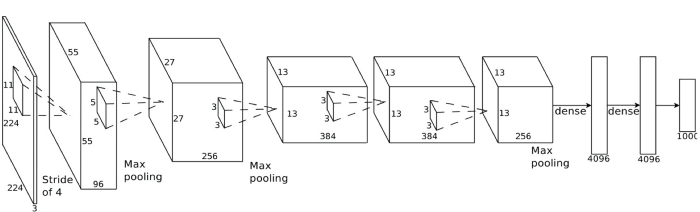


In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compiling the model and preparing it

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [ ]:
epochs=10
history = model.fit(
  treino_ds,
  validation_data=valida_ds,
  epochs=epochs
)

Epoch 1/10
115/115 [==============================] - 109s 949ms/step - loss: 0.2831 - accuracy: 0.8760 - val_loss: 0.1061 - val_accuracy: 0.9687
Epoch 2/10
115/115 [==============================] - 107s 928ms/step - loss: 0.1043 - accuracy: 0.9633 - val_loss: 0.1117 - val_accuracy: 0.9508
Epoch 3/10
115/115 [==============================] - 108s 940ms/step - loss: 0.0841 - accuracy: 0.9669 - val_loss: 0.0922 - val_accuracy: 0.9616
Epoch 4/10
115/115 [==============================] - 105s 917ms/step - loss: 0.0790 - accuracy: 0.9734 - val_loss: 0.0901 - val_accuracy: 0.9642
Epoch 5/10
115/115 [==============================] - 108s 935ms/step - loss: 0.0569 - accuracy: 0.9800 - val_loss: 0.0768 - val_accuracy: 0.9731
Epoch 6/10
115/115 [==============================] - 107s 932ms/step - loss: 0.0404 - accuracy: 0.9860 - val_loss: 0.0805 - val_accuracy: 0.9719
Epoch 7/10
115/115 [==============================] - 105s 915ms/step - loss: 0.0360 - accuracy: 0.9869 - val_loss: 0.0665 -

## Testing its accuracy and its distribution

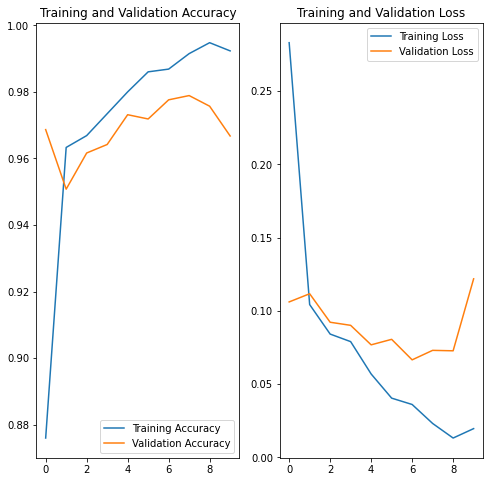

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Iremos agora fazer um pequeno teste de predição

In [ ]:
img = keras.preprocessing.image.load_img('/content/drive/My Drive/Pulmão/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg', target_size= (img_height, img_width), color_mode='grayscale', )

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])

In [ ]:
print(
    "Essa imagem pertence ao grupo {} com uma confiança de {:.2f}"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Essa imagem pertence ao grupo PNEUMONIA com uma confiança de 100.00
